<a href="https://www.kaggle.com/code/sagorkumarmitra/timeseries-forecasting-for-weather-prediction?scriptVersionId=146066092" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)


13568290/13568290 [==============================] - 2s 0us/step


# Visualization

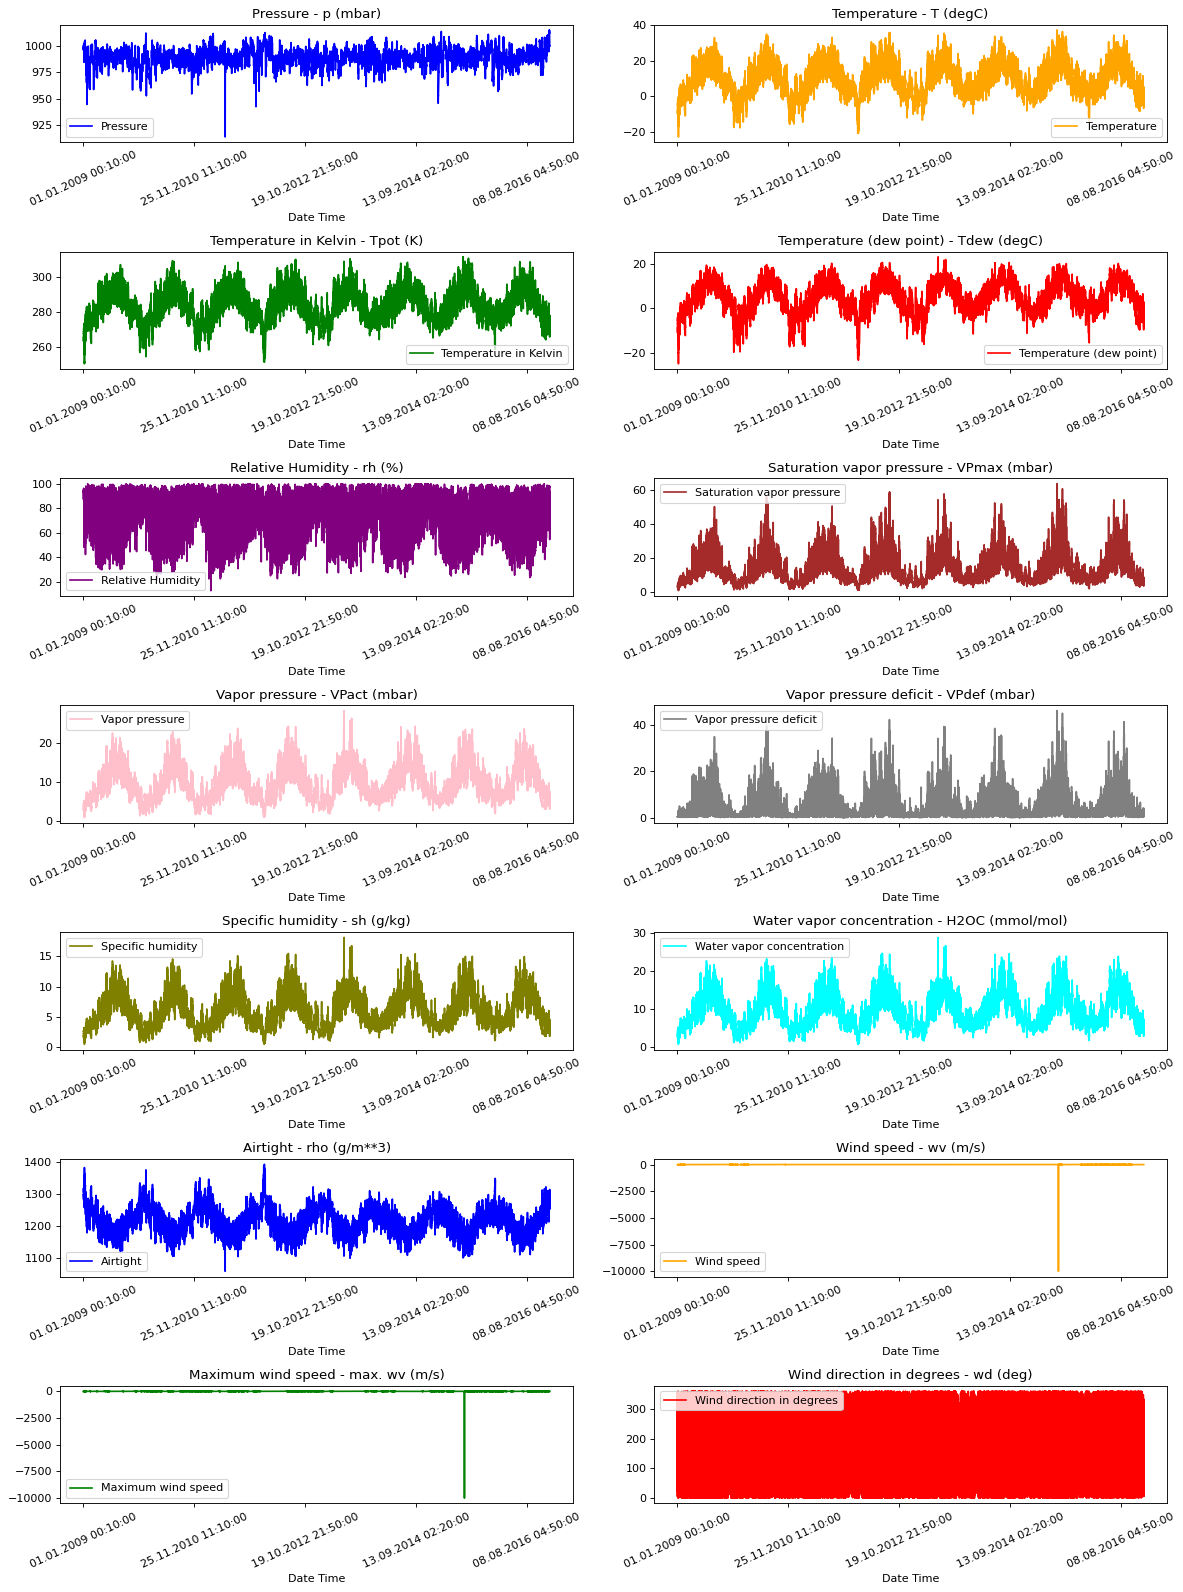

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

# Heatmap

<ipython-input-4-cf6ad4dd723a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

  plt.matshow(data.corr())


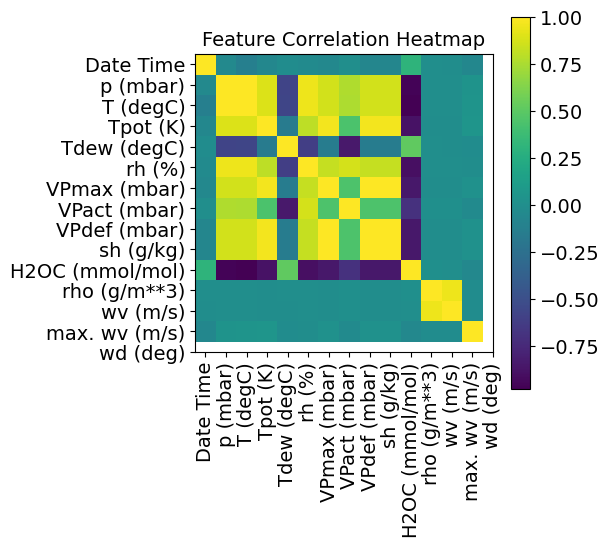

In [4]:

def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


In [5]:
df.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


In [6]:
df.tail(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.8,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.7,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


In [7]:
df.shape

(420551, 15)

In [8]:
df[:10].mean(axis=0)

<ipython-input-8-56a20fdbf198>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

  df[:10].mean(axis=0)


p (mbar)            996.517
T (degC)             -8.115
Tpot (K)            265.310
Tdew (degC)          -8.911
rh (%)               93.940
VPmax (mbar)          3.310
VPact (mbar)          3.109
VPdef (mbar)          0.200
sh (g/kg)             1.943
H2OC (mmol/mol)       3.120
rho (g/m**3)       1308.223
wv (m/s)              0.405
max. wv (m/s)         0.840
wd (deg)            172.360
dtype: float64

# Normalization

In [9]:
split_fraction=0.715
train_split=int(split_fraction * int(df.shape[0]))
step=6

past=720
future=72
learning_rate=0.001
batch_size=256
epochs=10

def normalize(data, train_split):
  data_mean=data[:train_split].mean(axis=0)
  data_std=data[:train_split].std(axis=0)
  return (data-data_mean) / data_std

In [10]:
train_split

300693

# Select Features

In [11]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [12]:
titles

['Pressure',
 'Temperature',
 'Temperature in Kelvin',
 'Temperature (dew point)',
 'Relative Humidity',
 'Saturation vapor pressure',
 'Vapor pressure',
 'Vapor pressure deficit',
 'Specific humidity',
 'Water vapor concentration',
 'Airtight',
 'Wind speed',
 'Maximum wind speed',
 'Wind direction in degrees']

In [13]:
feature_keys

['p (mbar)',
 'T (degC)',
 'Tpot (K)',
 'Tdew (degC)',
 'rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

In [14]:
selected_features=[feature_keys[i] for i in [0,1,5,7,8,10,11]]
features=df[selected_features]
features.index=df[date_time_key]
features.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


In [15]:
features=normalize(features.values,train_split)
features=pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [16]:
features.shape

(420551, 7)

In [17]:
train_data=features.loc[0:train_split-1]
val_data=features.loc[train_split:]

# Training dataset

In [18]:
train_data

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944
...,...,...,...,...,...,...,...
300688,-0.104339,0.853478,0.713250,-0.116113,1.429472,-0.878353,-0.890162
300689,-0.101908,0.881272,0.752322,-0.024521,1.392285,-0.900138,-0.477604
300690,-0.111631,0.902117,0.780974,0.021274,1.392285,-0.920454,-0.791934
300691,-0.117708,0.896327,0.771857,0.012948,1.388566,-0.916538,-0.791934


In [19]:
train_split

300693

In [20]:
start=past+future # 792
end=start+train_split # 792+300693

x_train=train_data[[i for i in range(7)]].values
y_train=features.iloc[start:end][[1]]

sequence_length=int(past/step)

In [21]:
features.iloc[:(792+300693)].shape

(301485, 7)

In [22]:
x_train.shape

(300693, 7)

In [23]:
y_train.shape

(300693, 1)

In [24]:
past

720

In [25]:
step

6

In [26]:
720/6

120.0

In [27]:
dataset_train=keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# Validation Dataset

In [28]:
val_data

,0,1,2,3,4,5,6
300693,-0.109200,0.855794,0.717157,-0.072399,1.384847,-0.879577,-0.942551
300694,-0.110416,0.852320,0.711948,-0.078644,1.381128,-0.876639,-1.302721
300695,-0.107985,0.788626,0.627292,-0.205623,1.373691,-0.820830,-1.197944
300696,-0.109200,0.734196,0.556963,-0.305541,1.358816,-0.773343,-1.217590
300697,-0.109200,0.679767,0.487936,-0.386725,1.325347,-0.724388,-0.667512
...,...,...,...,...,...,...,...
420546,1.386902,-1.540264,-1.164797,-0.580316,-1.456301,1.876123,-0.968745
420547,1.369887,-1.459199,-1.132237,-0.534520,-1.452583,1.789472,-0.660963
420548,1.356518,-1.437195,-1.123121,-0.511622,-1.460020,1.763770,-0.700254
420549,1.355303,-1.561109,-1.172611,-0.571990,-1.482333,1.890320,-0.431764


In [29]:
119858 - 720- 72

119066

In [30]:
300693 + 720+72

301485

In [31]:
x_end=len(val_data)-past-future
label_start=train_split + past+future

x_val=val_data.iloc[:x_end][[i for i in range(7)]].values
y_val=features.iloc[label_start:][[1]]

dataset_val=keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
  inputs,targets=batch

print("Input:", inputs.numpy().shape)
print("Target:", targets.numpy().shape)

Input: (256, 120, 7)

Target: (256, 1)


In [32]:
inputs.shape

TensorShape([256, 120, 7])

# Training

In [33]:
inputs=keras.layers.Input(shape=(inputs.shape[1],inputs.shape[2]))
lstm_out=keras.layers.LSTM(32)(inputs)
outputs=keras.layers.Dense(1)(lstm_out)
model=keras.Model(inputs=inputs,outputs=outputs)


model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss="mse")
model.summary()

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 120, 7)]          0         

                                                                 

 lstm (LSTM)                 (None, 32)                5120      

                                                                 

 dense (Dense)               (None, 1)                 33        

                                                                 


Total params: 5153 (20.13 KB)

Trainable params: 5153 (20.13 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________


# Callbacks

In [34]:
path_checkpoint="model_checkpoint.h5"
es_callback=keras.callbacks.EarlyStopping(monitor="val_loss",
                                          min_delta=0,
                                          patience=5)
modelckpt_callback=keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history=model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback,modelckpt_callback],
)

Epoch 1/10

1171/1172 [============================>.] - ETA: 0s - loss: 0.1791

Epoch 1: val_loss improved from inf to 0.15135, saving model to model_checkpoint.h5

1172/1172 [==============================] - 68s 52ms/step - loss: 0.1790 - val_loss: 0.1513

Epoch 2/10

1171/1172 [============================>.] - ETA: 0s - loss: 0.1217

Epoch 2: val_loss improved from 0.15135 to 0.14177, saving model to model_checkpoint.h5

1172/1172 [==============================] - 57s 49ms/step - loss: 0.1217 - val_loss: 0.1418

Epoch 3/10

1171/1172 [============================>.] - ETA: 0s - loss: 0.1129

Epoch 3: val_loss did not improve from 0.14177

1172/1172 [==============================] - 57s 48ms/step - loss: 0.1129 - val_loss: 0.1535

Epoch 4/10

1171/1172 [============================>.] - ETA: 0s - loss: 0.1089

Epoch 4: val_loss did not improve from 0.14177

1172/1172 [==============================] - 56s 48ms/step - loss: 0.1089 - val_loss: 0.1602

Epoch 5/10

1171/1172 [=======

# Visualize the loss

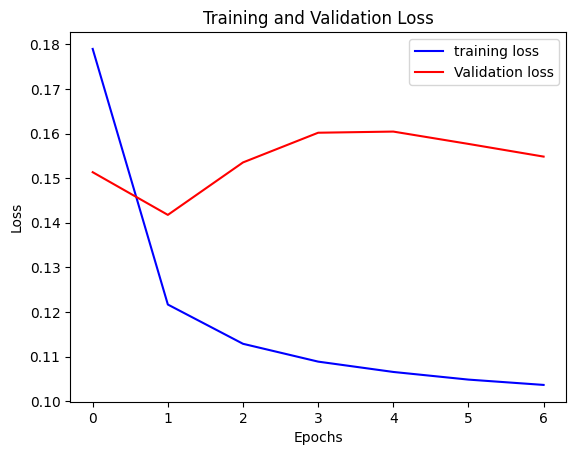

In [35]:
def visualize_loss(history,title):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  epochs=range(len(loss))
  plt.figure()
  plt.plot(epochs,loss,"b",label="training loss")
  plt.plot(epochs,val_loss,"r",label="Validation loss")
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

visualize_loss(history, "Training and Validation Loss")

# Prediction

In [ ]:
plot_data

8/8 [==============================] - 1s 5ms/step


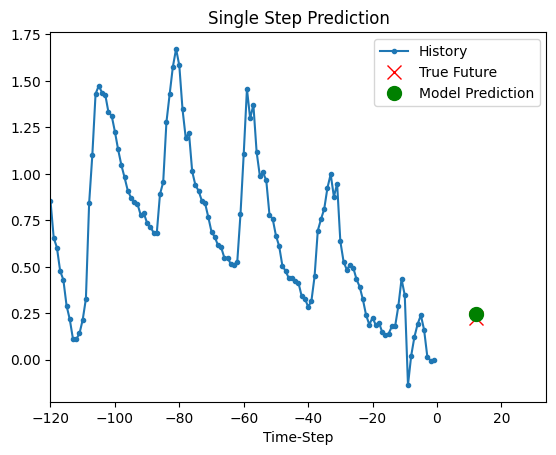

8/8 [==============================] - 0s 4ms/step


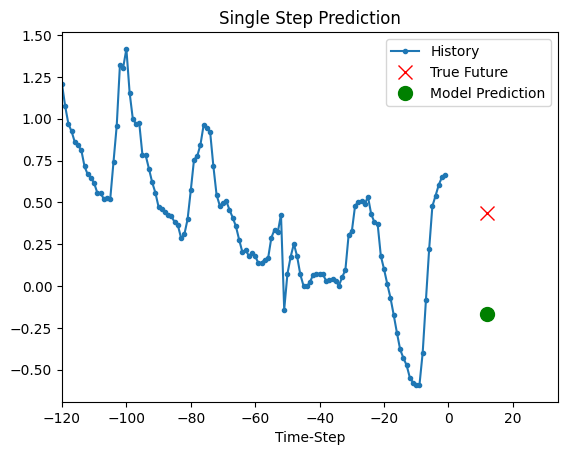

8/8 [==============================] - 0s 5ms/step


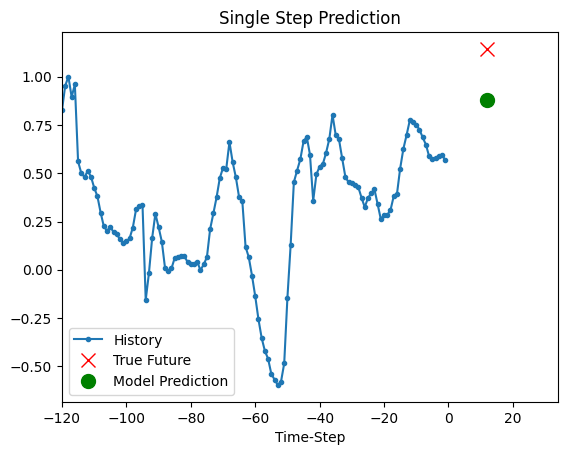

8/8 [==============================] - 0s 5ms/step


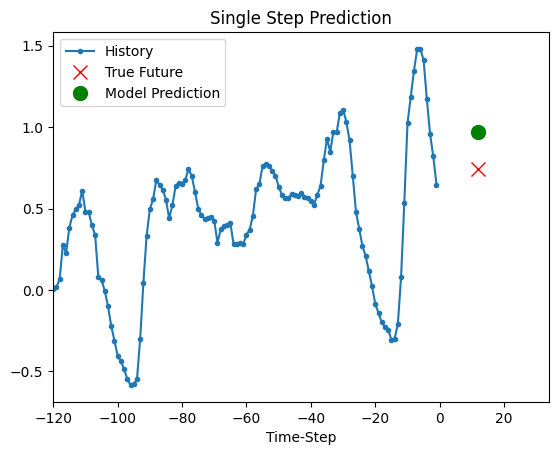

8/8 [==============================] - 0s 7ms/step


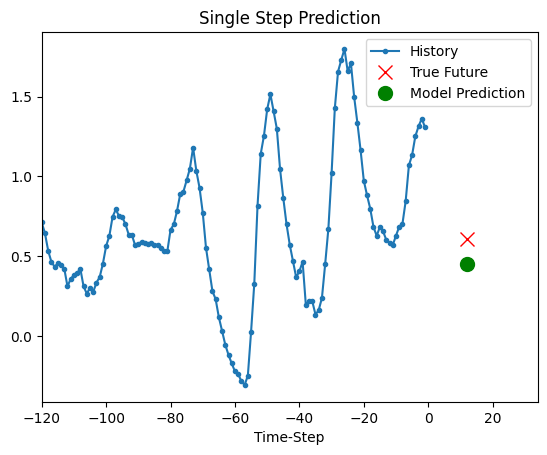

In [37]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )